In [2]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics

from utils_train import (checksum, determine_image_center, shadow_regions, 
                         half_skeletonize, randomly_distribute, systemic_brightening,
                        make_nonzero_dict)

In [3]:
os.chdir("/users/riya/race/classifier_experiments")

In [4]:
!nvidia-smi

Mon Jul 18 14:46:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   57C    P0    60W / 149W |  11355MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [3]:
!pip install numba

     |████████████████████████████████| 3.4 MB 2.1 MB/s            
     |████████████████████████████████| 25.3 MB 24.7 MB/s            


In [4]:
from numba import jit, cuda
from timeit import default_timer as timer

# Visualizations

Working with trained CNN models by means of: .csv prediction files, .pth files, and more!

In [5]:
def get_acc(true_values, probabilities):
   
    true_values = true_values.reset_index(drop=True)
    probabilities = probabilities.reset_index(drop=True)

    assert len(true_values) == len(probabilities)
    num_elements = len(true_values)
    same_elements = 0
    
    for i in range(num_elements):
        rounded_prob = round(probabilities[i])
        if true_values[i] == rounded_prob:
            same_elements += 1
    
    acc = same_elements/num_elements
    acc = 1 - acc
            
    acc = np.round(acc,4) # 1 - just to get the percent misclassified
    
    return acc

In [8]:
test_img = mpimg.imread("/users/riya/race/dataset/segmentations/18168.bmp")

In [9]:
test_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Brightening Sums

In [6]:
def visualize_system_brightening_images(img_id, brighten_sums, skeleton = False): 
    
    num_images = len(brighten_sums)
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = systemic_brightening(img, skeleton, 'below', 'brighten', brighten_sums[i])
        visualize_image2 = systemic_brightening(img, skeleton, 'below', 'dull', brighten_sums[i])
        # visualize_image2 = systemic_brightening(img, skeleton, 'above', brighten_sums[i])
        
        # bad code here
        print('larger vessels brightened by, ',brighten_sums[i])
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('smaller vessels dulled by, ',brighten_sums[i])
        plt.imshow(visualize_image2, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

In [ ]:
brighten_sums_arr = [0, 30, 60, 90, 120, 150]
visualize_system_brightening_images(18168, brighten_sums_arr, False)

In [21]:
def make_systemic_brightening_vertical_stack(img_id, intensity_change, brighten_sum,
                                            skeleton = False): # per image
    img = mpimg.imread(f"/users/riya/race/dataset/segmentations/{img_id}.bmp")
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    if intensity_change == 'brighten':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'brighten', brighten_sum)

    if intensity_change == 'dull':
        visualize_image = systemic_brightening(img, skeleton, 'below', 'dull', brighten_sum)
    
    return visualize_image

In [24]:
# apply to each brighten_sum
brighten_sums_arr = [0, 30, 60, 90, 120, 150]

<Figure size 432x288 with 0 Axes>

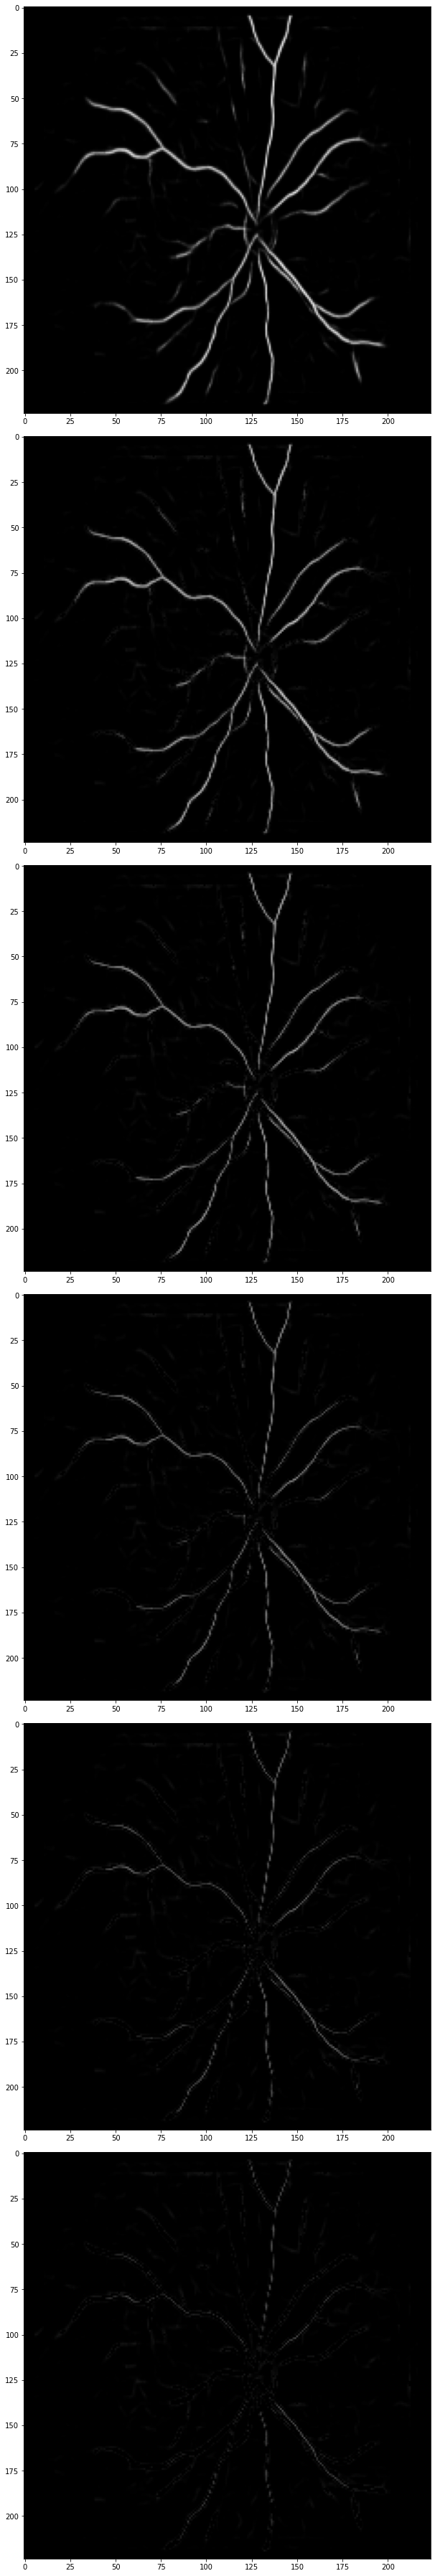

In [36]:
plt.figure()

f, axarr = plt.subplots(6, 1)

f.set_figheight(50)
f.set_figwidth(50)

f.tight_layout()

for i in range(len(brighten_sums_arr)):
    display_img = make_systemic_brightening_vertical_stack(18168, 'dull', brighten_sums_arr[i])
    # axarr[i].set_xticks([])
    axarr[i].imshow(display_img)

In [12]:
def make_systemic_brightening_roc_plot(path, epoch, brighten_sums, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
    
    # we only have thresholding below cases (where pixels are untouched below the threshold of 20)
    
    label = ''
    
    files=os.listdir(path)
    paths = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    final_paths = []
    labels_arr = []
    img_counter = len(brighten_sums)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 3: # means 2 radiuses, as expected
                brighten_sum = path_nums[0] # last is epoch number, 50
                if brighten_sum == brighten_sums[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, paths[j])
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    # final_paths = ['original_epoch50.csv']
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        
        # return test_predictions

        black_predictions = test_predictions[test_predictions['race'] == 0]        
        white_predictions = test_predictions[test_predictions['race'] == 1]
        
        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # Overall Kappa TIME!
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities   
        kappa = np.round(kappa, 4) 
        
        # White ACC time!
        
        # print(white_predictions['race'])
        # print(1 - white_predictions['probability']) 
        
        white_acc = get_acc(white_predictions['race'],  1 - white_predictions['probability']) 
        # 1 - to get the probability of the white class!
        
        # Black ACC time
        
        black_acc = get_acc(black_predictions['race'],  1 - black_predictions['probability']) # black class probability
                          
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", kappa ="+str(kappa) + ", white_acc ="+str(white_acc) 
                + ", black_acc ="+str(black_acc))

    plt.legend(loc=4)
    plt.show()      

['systemic_dulled_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_120_above_20_epoch50.csv'
 'systemic_brightening_by_150_above_20_epoch50.csv']
['systemic_dulled_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_30_above_20_epoch50.csv'
 'systemic_brightening_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_60_above_20_epoch50.csv'
 'systemic_dulled_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_90_above_20_epoch50.csv'
 'systemic_brightening_by_120_above_20_epoch50.csv'
 'systemic_brightening_by_150_above_20_epoch50.csv']


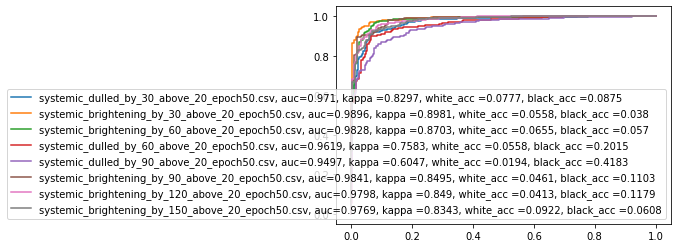

In [13]:
brighten_sums_string_arr = ['0', '30', '60', '90', '120', '150']
make_systemic_brightening_roc_plot("./CNN_train/outputs/probabilities/#9(systemic_brightening)/", 
                                   50, brighten_sums_string_arr)

Perhaps look at the number of images predicted white, or the number of white images incorrectly predicted. Let's do that!

## Random Pixels

In [4]:
def visualize_random_images(img_id, brighten_sums, median_number_of_pixels, skeleton, average_nonzero_pixels): 
    
    num_images = len(brighten_sums)
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        
    for i in range(num_images):
        visualize_image = randomly_distribute(img, skeleton, average_nonzero_pixels, median_number_of_pixels, brighten_sums[i])
        
        # bad code here
        print('brightened by, ',brighten_sums[i])
        plt.imshow(visualize_image, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

In [5]:
number_of_pixels = 11170 # median is 11170.5

brighten_sums_arr = [0, 20, 40, 60, 80, 100, 120]
visualize_random_images(18168, brighten_sums_arr, number_of_pixels, False, True)

13047


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

brightened by,  0


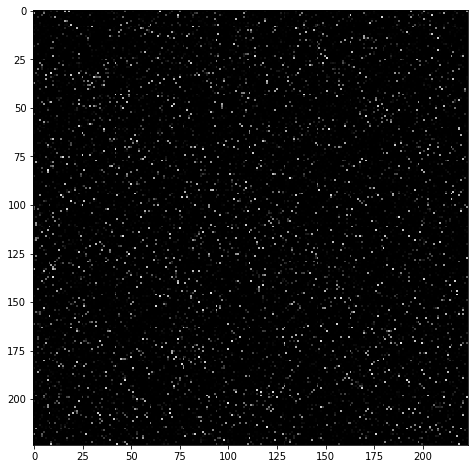

brightened by,  20


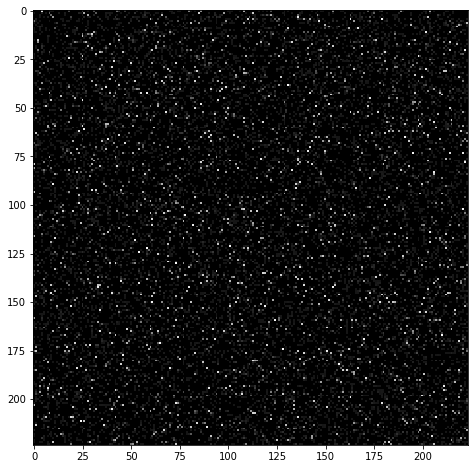

brightened by,  40


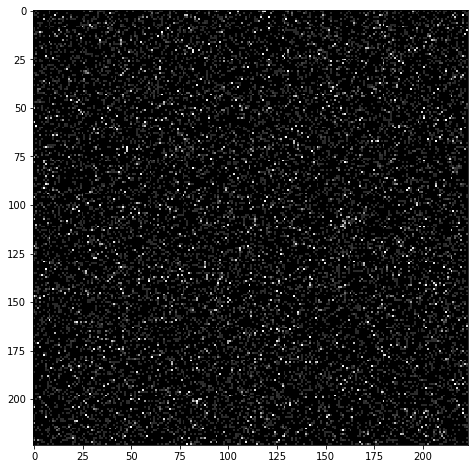

brightened by,  60


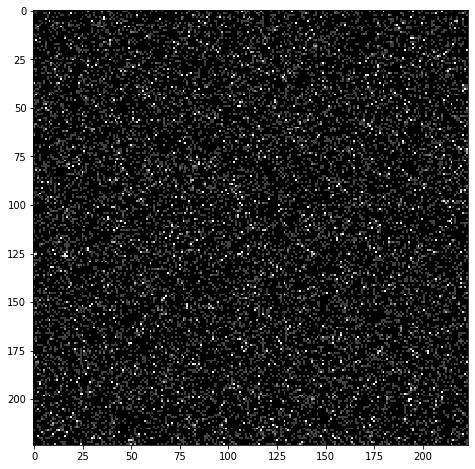

brightened by,  80


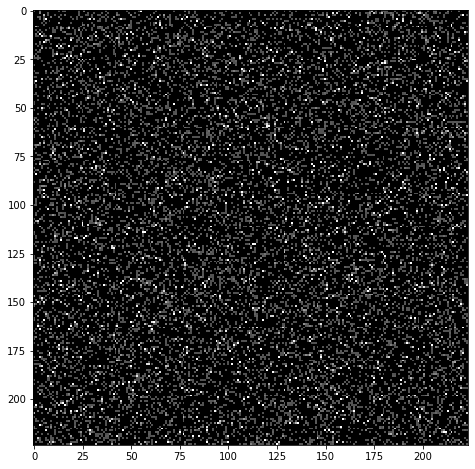

brightened by,  100


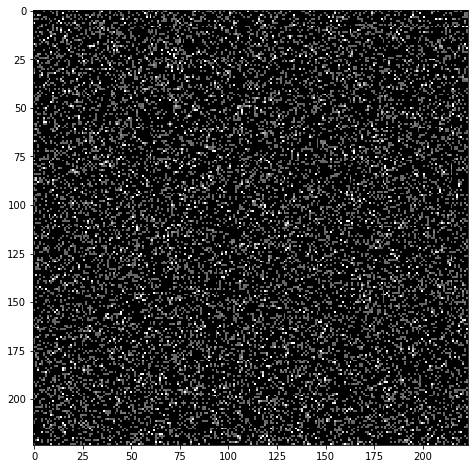

brightened by,  120


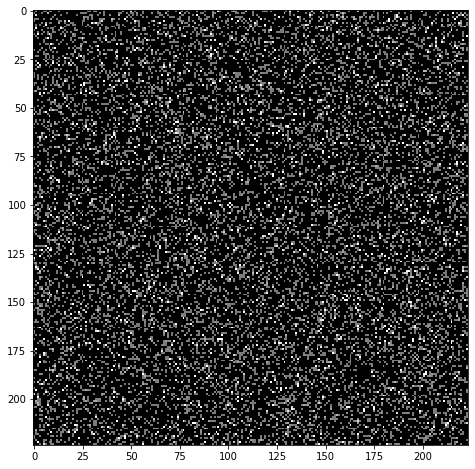

In [4]:
brighten_sums_arr = [0, 20, 40, 60, 80, 100, 120]
visualize_random_images(18168, brighten_sums_arr, False)

brightened by,  0


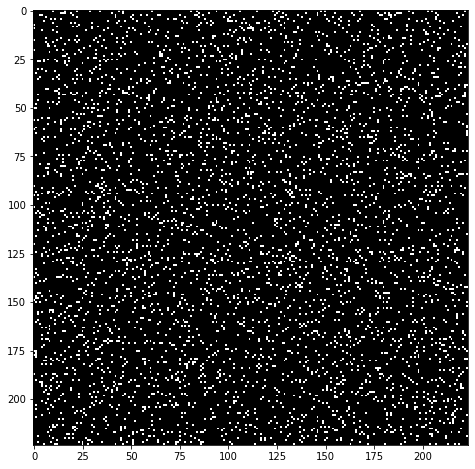

In [8]:
visualize_random_images(18168, [0], True)

In [17]:
def make_random_roc_plot(path, epoch, brighten_sums, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
        
    label = ''
    
    files=os.listdir(path)
    paths = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    final_paths = []
    labels_arr = []
    img_counter = len(brighten_sums)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 2: # means 2 radiuses, as expected
                brighten_sum = path_nums[0] # last is epoch number, 50
                if brighten_sum == brighten_sums[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, paths[j])
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    final_paths = ['original_epoch50.csv']
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        
        # return test_predictions

        black_predictions = test_predictions[test_predictions['race'] == 0]        
        white_predictions = test_predictions[test_predictions['race'] == 1]
        
        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # Overall Kappa TIME!
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities   
        kappa = np.round(kappa, 4) 
        
        # White ACC time!
        
        # print(white_predictions['race'])
        # print(1 - white_predictions['probability']) 
        
        white_acc = get_acc(white_predictions['race'],  1 - white_predictions['probability']) 
        # 1 - to get the probability of the white class!
        
        # Black ACC time
        
        black_acc = get_acc(black_predictions['race'],  1 - black_predictions['probability']) # black class probability
                          
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", kappa ="+str(kappa) + ", white_acc ="+str(white_acc) 
                + ", black_acc ="+str(black_acc))

    plt.legend(loc=4)
    plt.show()       

['original_epoch50.csv']
['shadow_regions_dark_center_60_skeletonized_epoch50.csv'
 'shadow_regions_dark_center_60_epoch50.csv'
 'shadow_regions_dark_background_60_epoch50.csv'
 'shadow_regions_dark_background_60_skeletonized_epoch50.csv'
 'shadow_regions_dark_background_120_epoch50.csv'
 'shadow_regions_dark_center_120_epoch50.csv'
 'shadow_regions_dark_center_120_skeletonized_epoch50.csv'
 'shadow_regions_dark_background_120_skeletonized_epoch50.csv']


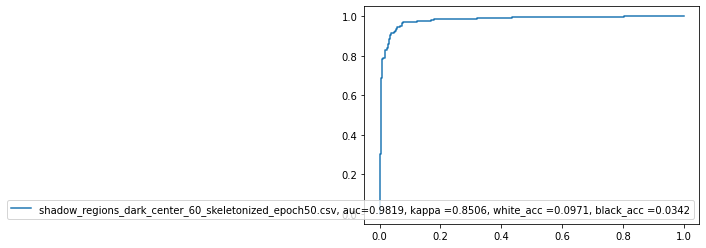

In [18]:
sum_strings = ['0', '20', '40', '60', '80', '100', '120']
make_random_roc_plot("./CNN_train/outputs/probabilities/", 50, sum_strings,
                     insert_indexes = [], my_paths = [], my_labels=[])

In [19]:
os.listdir("/users/riya/race/dataset/segmentations/")

['101934.bmp',
 '82379.bmp',
 '87427.bmp',
 '49236.bmp',
 '45251.bmp',
 '87380.bmp',
 '39426.bmp',
 '43868.bmp',
 '101127.bmp',
 '102795.bmp',
 '75672.bmp',
 '96850.bmp',
 '84991.bmp',
 '102482.bmp',
 '76802.bmp',
 '100470.bmp',
 '87351.bmp',
 '101709.bmp',
 '92816.bmp',
 '50212.bmp',
 '96908.bmp',
 '51452.bmp',
 '44598.bmp',
 '71523.bmp',
 '39208.bmp',
 '107523.bmp',
 '18158.bmp',
 '38448.bmp',
 '106415.bmp',
 '70415.bmp',
 '92773.bmp',
 '60147.bmp',
 '104340.bmp',
 '90781.bmp',
 '33352.bmp',
 '33887.bmp',
 '30626.bmp',
 '34738.bmp',
 '40791.bmp',
 '13223.bmp',
 '102388.bmp',
 '101948.bmp',
 '81671.bmp',
 '17219.bmp',
 '12547.bmp',
 '91455.bmp',
 '30074.bmp',
 '25619.bmp',
 '101999.bmp',
 '74359.bmp',
 '9161.bmp',
 '47090.bmp',
 '88766.bmp',
 '45062.bmp',
 '17390.bmp',
 '68355.bmp',
 '84360.bmp',
 '19764.bmp',
 '96167.bmp',
 '34453.bmp',
 '47356.bmp',
 '48583.bmp',
 '94632.bmp',
 '87275.bmp',
 '45403.bmp',
 '98123.bmp',
 '98684.bmp',
 '50179.bmp',
 '29431.bmp',
 '70008.bmp',
 '34744.b

## Half Skeletonize

In [3]:
def visualize_skeleton_images(img_id, skeleton_radiuses): 
    
    # if doing just shadow: shadow_radiuses is radius of shadow circle
    # if doing shadow rings, shadow_rings is array of array of outer/inner ring radiuses
    
    num_images = len(skeleton_radiuses)
    
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    # based on checksums, bc function is. 
    # if we get one of those duplicates/incorrect images, will manually put disk center, or change img
    
    QA_csv, checksum_dict = checksum("../optic_disk/DeepROP/quality_assurance/QA.csv")
    disk_center = determine_image_center(img, (224, 224), QA_csv, checksum_dict) 
    
    print(disk_center)
    
    
    # write if conditions for other scenarios as I need to visualize them
    
    for i in range(num_images):
        skeleton_center_img = half_skeletonize(img, disk_center, skeleton_radiuses[i], 
                                         'skeleton_center') # image_size = (224, 224)
        pain = half_skeletonize(img, disk_center, skeleton_radiuses[i], 
                                       'skeleton_background')
        
        # bad code here
        print('skeleton center, ',skeleton_radiuses[i])
        plt.imshow(skeleton_center_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('skeleton background, ',skeleton_radiuses[i])
        plt.imshow(pain, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

100%|██████████| 3371/3371 [00:10<00:00, 328.28it/s]


(129, 123)
skeleton center,  [0, 15]


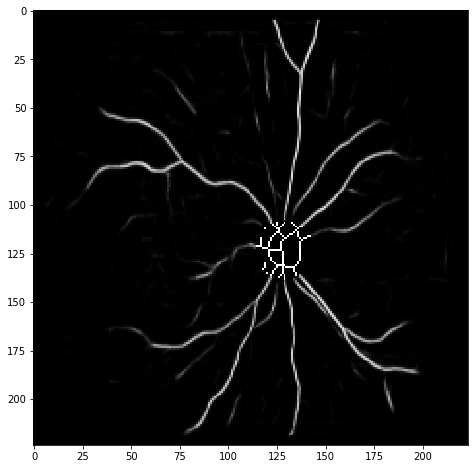

skeleton background,  [0, 15]


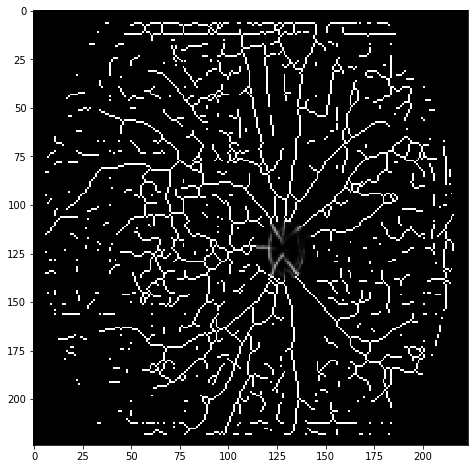

skeleton center,  [0, 30]


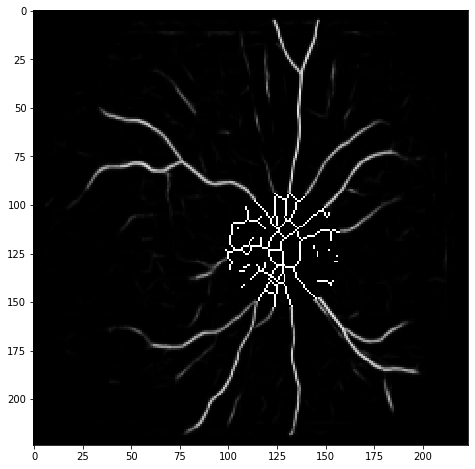

skeleton background,  [0, 30]


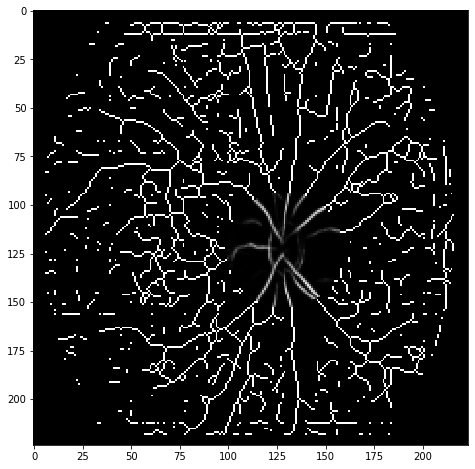

skeleton center,  [0, 45]


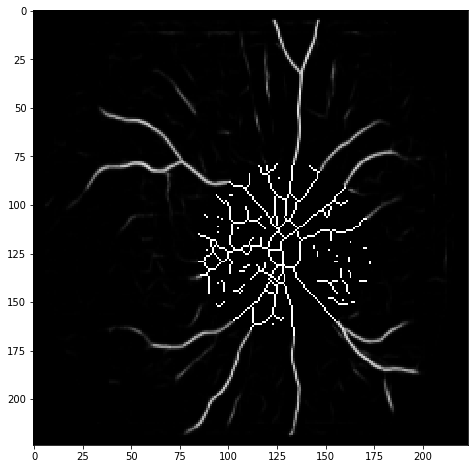

skeleton background,  [0, 45]


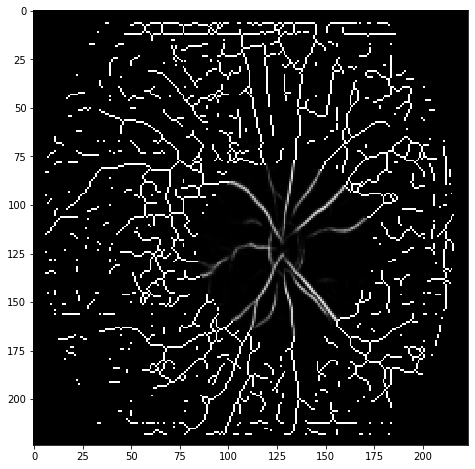

skeleton center,  [0, 60]


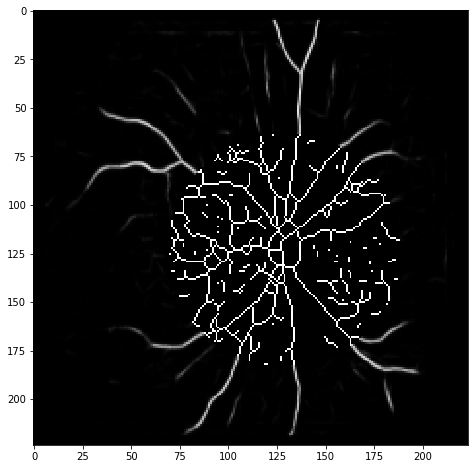

skeleton background,  [0, 60]


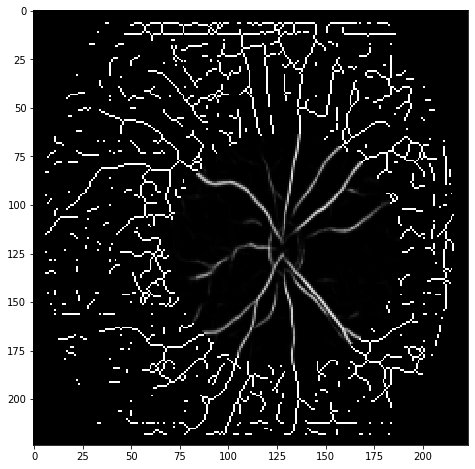

skeleton center,  [0, 75]


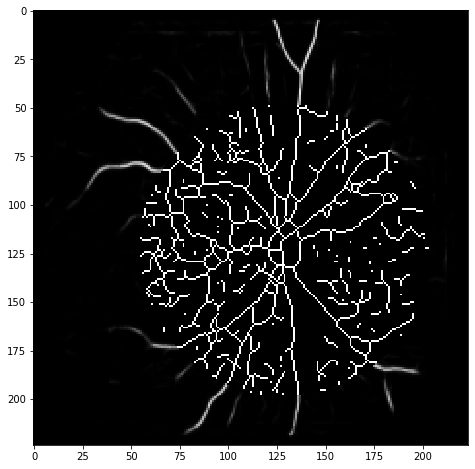

skeleton background,  [0, 75]


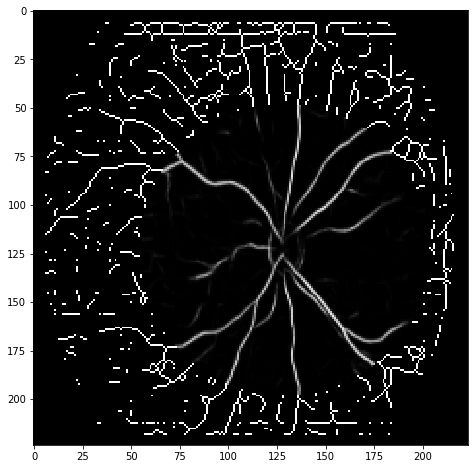

skeleton center,  [0, 90]


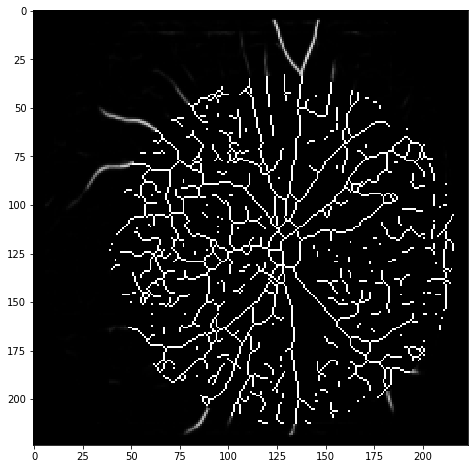

skeleton background,  [0, 90]


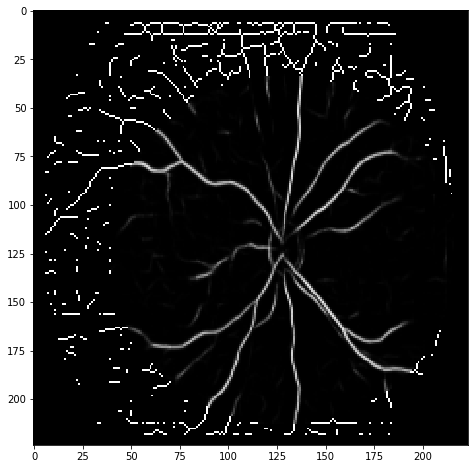

skeleton center,  [0, 105]


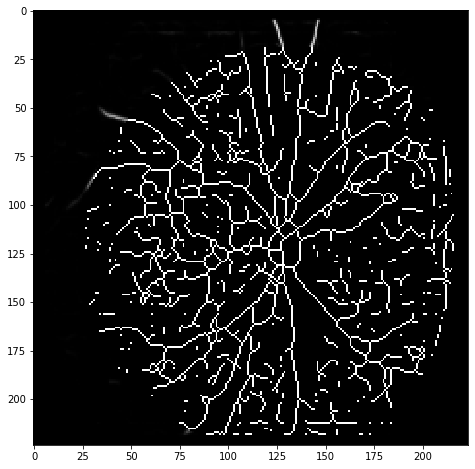

skeleton background,  [0, 105]


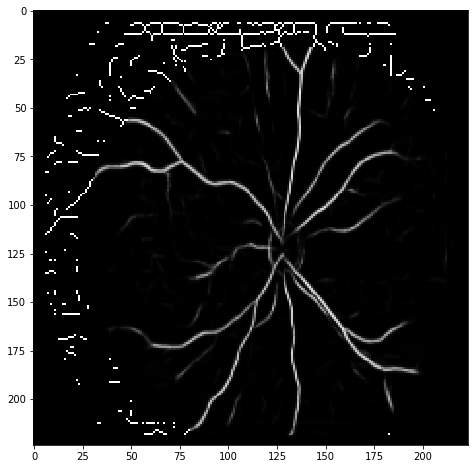

skeleton center,  [0, 120]


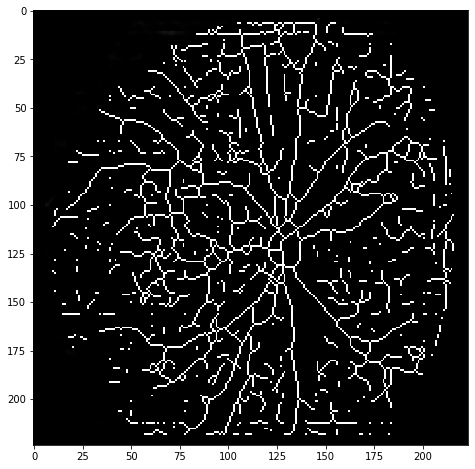

skeleton background,  [0, 120]


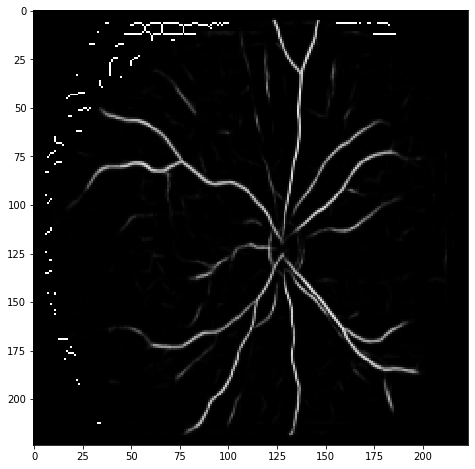

In [4]:
skeleton_radiuses = [[0, 15], [0, 30], [0,45], [0,60], [0,75], [0,90], [0, 105], [0,120]]
visualize_skeleton_images(18168, skeleton_radiuses)

In [109]:
def make_skel_roc_plot(path, epoch, skeleton_radiuses, region, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
        
    label = ''
    
    files=os.listdir(path)
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if region == 'skeleton_center':
        paths = [p for p in csvs if "skeleton_center" in p]
        
    elif region == 'skeleton_background':
        paths = [p for p in csvs if "skeleton_background" in p]
    
    # narrowing down paths by radiuses I Want
    # print (len(paths))
    
    final_paths = []
    labels_arr = []
    img_counter = len(skeleton_radiuses)
        
    for i in range(img_counter):
        for j in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[j])

            if len(path_nums) == 3: # means 2 radiuses, as expected
                radius_arr = [path_nums[0], path_nums[1]] # last is epoch number, 50
                if radius_arr == skeleton_radiuses[i] and paths[j] not in final_paths:
                    final_paths = np.append(final_paths, paths[j])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + 
                                               " (partially skeletonized)")
                    img_counter -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        

        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # AUPROC time!
        
        au_proc = metrics.average_precision_score(test_predictions['race'], 1 - test_predictions['probability'])
        au_proc = np.round(au_proc, 4)
        
        # KAPPA time!
        # need to get predicted labels (so round up or down)
        
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities
        
        
        # quick test 
        
        uncommon_elements = 0 
        
        for p in range(len(kappa_labels)):
            if kappa_labels[p] != test_predictions['race'][p]:
                uncommon_elements+=1
        # print(uncommon_elements)
        # print(len(kappa_labels))
        
        kappa = np.round(kappa, 4)                             
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", auproc="+str(au_proc) + ", kappa ="+str(kappa))

    plt.legend(loc=4)
    plt.show()       

In [110]:
skeleton_string_radiuses = [['0', '15'], ['0', '30'], ['0','45'], ['0','60'], 
                            ['0','75'], ['0','90'], ['0', '105'], ['0','120']]

['half_skeletonize_skeleton_center_0_15_epoch50.csv'
 'half_skeletonize_skeleton_center_0_30_epoch50.csv'
 'half_skeletonize_skeleton_center_0_45_epoch50.csv'
 'half_skeletonize_skeleton_center_0_60_epoch50.csv'
 'half_skeletonize_skeleton_center_0_75_epoch50.csv'
 'half_skeletonize_skeleton_center_0_90_epoch50.csv'
 'half_skeletonize_skeleton_center_0_105_epoch50.csv'
 'half_skeletonize_skeleton_center_0_120_epoch50.csv']
['radius: 0 to 15 (partially skeletonized)'
 'radius: 0 to 30 (partially skeletonized)'
 'radius: 0 to 45 (partially skeletonized)'
 'radius: 0 to 60 (partially skeletonized)'
 'radius: 0 to 75 (partially skeletonized)'
 'radius: 0 to 90 (partially skeletonized)'
 'radius: 0 to 105 (partially skeletonized)'
 'radius: 0 to 120 (partially skeletonized)']


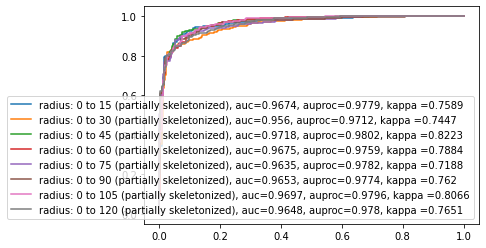

In [113]:
make_skel_roc_plot("./CNN_train/outputs/probabilities/#7(half_skeletonize)/", 50, skeleton_string_radiuses, 
                   'skeleton_center', insert_indexes = [], my_paths = [], my_labels=[])

In [112]:
!ls

CNN_train			  shadow_regions_experiment2_expanded.ipynb
CNN_visualization.ipynb		  shadow_regions_experiment3.ipynb
__pycache__			  shadow_regions_experiment4.ipynb
dataset				  train.ipynb
models				  train0.py
predictions			  train2.py
shadow_regions.ipynb		  train_half_skeletonize.py
shadow_regions_experiment2.ipynb  train_original.py


## Shadowed Images

In [ ]:
def visualize_images(img_id, skel, shadow, shadow_rings, num_rings, shadow_radiuses, img_count=0): 
    
    # if doing just shadow: shadow_radiuses is radius of shadow circle
    # if doing shadow rings, shadow_rings is array of array of outer/inner ring radiuses
    
    num_images = img_count
    
    
    img = np.array(Image.open(f"/users/riya/race/dataset/segmentations/{img_id}.bmp"))
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
    
    # based on checksums, bc function is. 
    # if we get one of those duplicates/incorrect images, will manually put disk center, or change img
    
    QA_csv, checksum_dict = checksum("../../optic_disk/DeepROP/quality_assurance/QA.csv")
    disk_center = determine_image_center(img, (224, 224), QA_csv, checksum_dict) 
    
    print(disk_center)
    
    if shadow is True and shadow_rings is not True:
        num_images = len(shadow_radiuses)
    elif shadow is True and shadow_rings is True:
        num_images = len(shadow_radiuses)
    
    # write if conditions for other scenarios as I need to visualize them
    
    for i in range(num_images):
        dark_center_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings,
                                         shadow_radiuses[i], 'dark_center', image_size = (224, 224))
        dark_back_img = shadow_regions(img, skel, disk_center, shadow, shadow_radiuses[i], shadow_rings, num_rings, 
                                       shadow_radiuses[i], 'dark_background', image_size = (224, 224))
        
        # bad code here
        print('dark center, ',shadow_radiuses[i])
        plt.imshow(dark_center_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()
        
        print('dark background, ',shadow_radiuses[i])
        plt.imshow(dark_back_img, interpolation = 'nearest')
        plt.gcf().set_size_inches(8,8)
        plt.show()

100%|██████████| 3371/3371 [00:10<00:00, 326.72it/s]


dark center,  [0, 30]


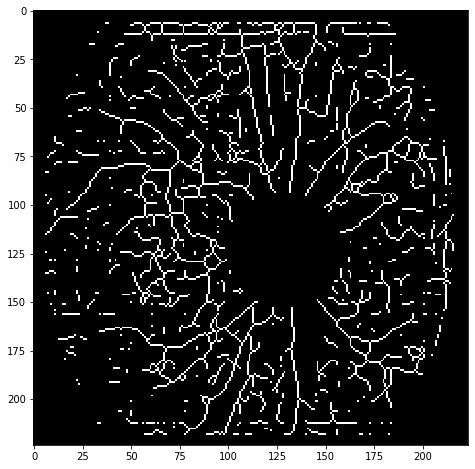

dark background,  [0, 30]


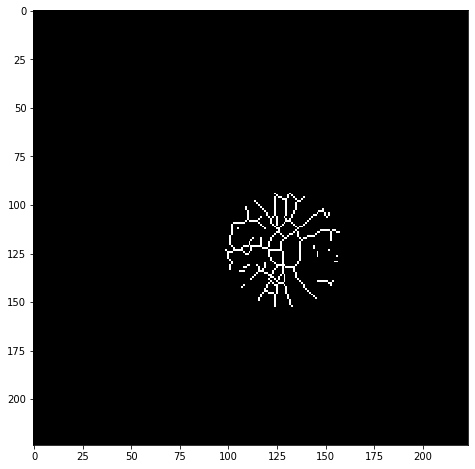

dark center,  [30, 60]


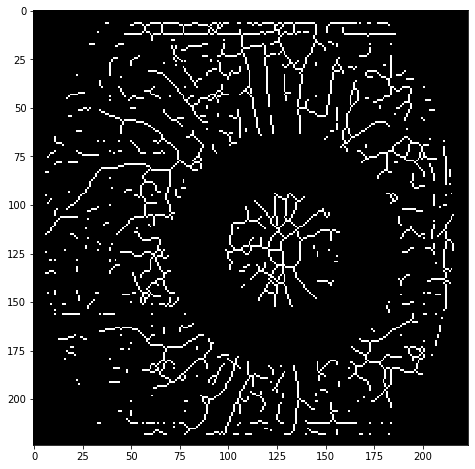

dark background,  [30, 60]


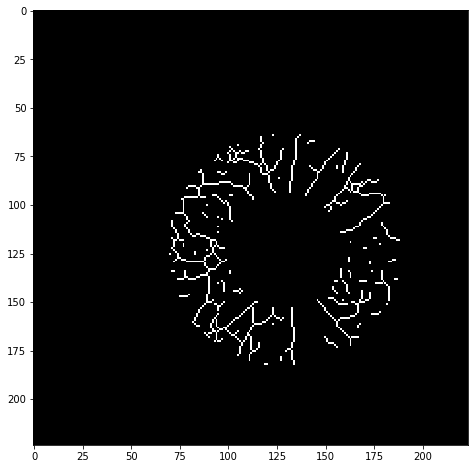

dark center,  [60, 90]


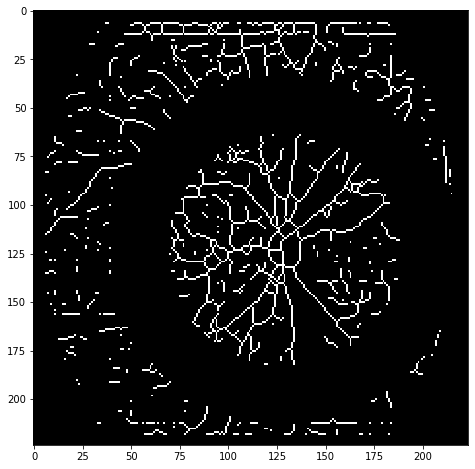

dark background,  [60, 90]


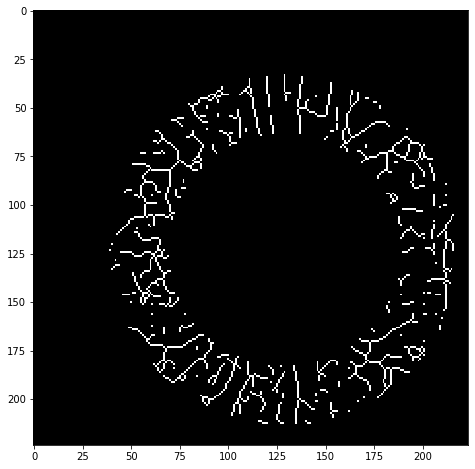

In [4]:
ring_radiuses = [[0, 30], [30, 60], [60, 90]]
visualize_images(18168, True, True, True, 1, ring_radiuses)

100%|██████████| 3371/3371 [00:13<00:00, 257.67it/s]


(58, 129)
dark center,  [[0, 15], [75, 90]]


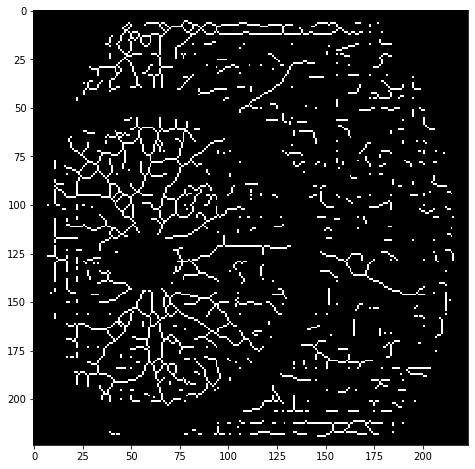

dark background,  [[0, 15], [75, 90]]


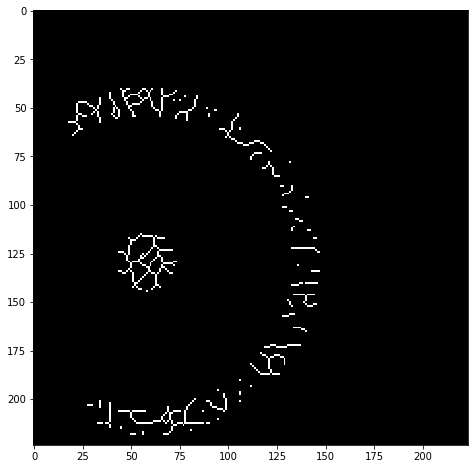

dark center,  [[0, 30], [60, 90]]


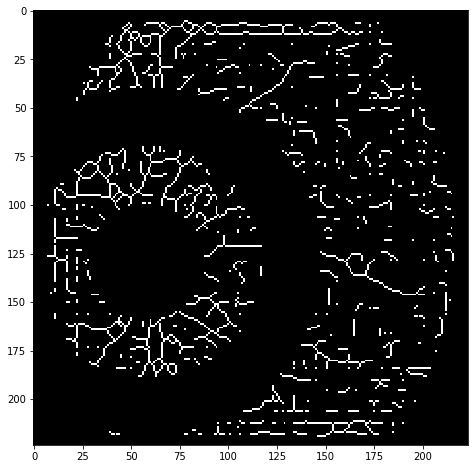

dark background,  [[0, 30], [60, 90]]


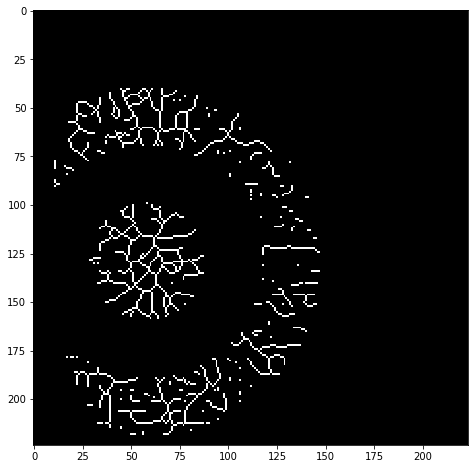

dark center,  [[0, 45], [45, 90]]


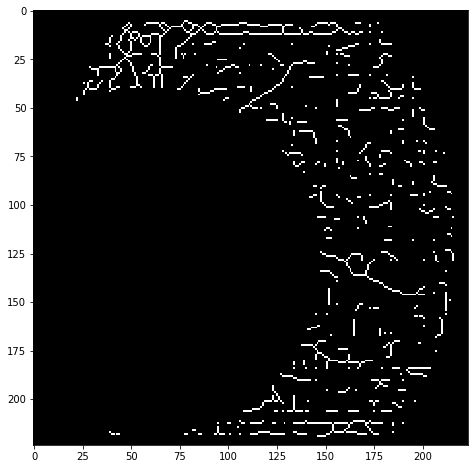

dark background,  [[0, 45], [45, 90]]


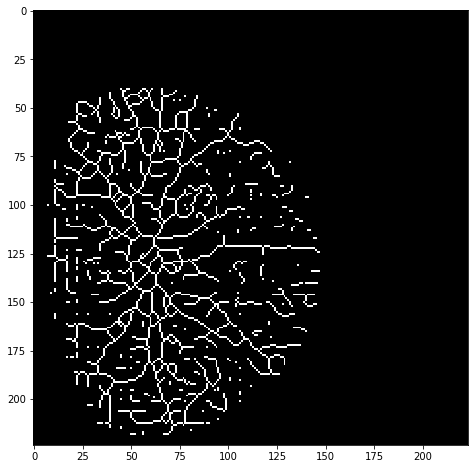

In [64]:
multi_ring_radiuses = [[[0, 15], [75,90]], [[0, 30], [60, 90]], [[0,45],[45, 90]]]
visualize_images(27313, True, True, True, 2, multi_ring_radiuses)

In [ ]:
def make_half_plot(path, epoch, skeleton, shadow, shadow_ring, shadow_radiuses, region, 
                  insert_indexes = [], my_paths = [], my_labels=[]): # up to 50, early stopping
    
    label = ''
    
    files=os.listdir(path)
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if skeleton:
        paths = [p for p in csvs if "skeletonized" in p or "skeletonized" in p and "shadow" not in p]
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "skeletonized" in p and "shadow" not in p] # original skeletonized
            elif shadow_ring is False:
                paths = [p for p in paths if "shadow" in p and "ring" not in p or "skeletonized" in p and "shadow" not in p]
        elif shadow is False:
            paths = [p for p in paths if "skeletonized" in p and "shadow" not in p] # only original skeletonized
        
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "skeletonized" in p and "shadow" not in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "skeletonized" in p and "shadow" not in p]
        
    if not skeleton:
        paths = [p for p in csvs if "skeletonized" not in p or "original" in p]  
        if shadow:
            if shadow_ring:
                paths = [p for p in paths if "shadow_rings" in p or "original" in p]
            elif shadow_ring is False:
                [p for p in paths if "shadow" in p and "ring" not in p or "original" in p]
        elif shadow is False:
            [p for p in paths if "original" in p] # only original skeletonized
         
        if region == 'dark_center':
            paths = [p for p in paths if "dark_center" in p or "original" in p]
        
        elif region == 'dark_background':
            paths = [p for p in paths if "dark_background" in p or "original" in p]
    
    # narrowing down paths by radiuses I Want
    # print (len(paths))
    
    final_paths = []
    labels_arr = []
    shadow_remove = len(shadow_radiuses)

    # to improve code, can store in variables and append only at the end.
    # how to organize this such that labels and paths are in the order that I want?
    
    for j in range(len(shadow_radiuses)): # getting this original in first order.
        for i in range(len(paths)):
            
            path_nums = re.findall(r'\d+', paths[i])
            
            if len(path_nums) == 1:
                if skeleton == True and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original skeletonized")
                    final_paths = np.append(final_paths, paths[i])
                elif skeleton == False and paths[i] not in final_paths:
                    labels_arr = np.append(labels_arr, "original")
                    final_paths = np.append(final_paths, paths[i])
        
    for j in range(len(shadow_radiuses)):
        for i in range(len(paths)):
            path_nums = re.findall(r'\d+', paths[i])

            if len(path_nums) == 2: # means there is 1 radius, and no rings
                if path_nums[0] == shadow_radiuses[j] and paths[i] not in final_paths: # to get them in the order I want!!!
                    # print(path_nums[0])
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0])
                    shadow_remove -= 1

            elif len(path_nums) == 3: # means 2 radiuses, shadow rings
                radius_arr = [path_nums[0], path_nums[1]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + " (ring)")
                    shadow_remove -= 1
            
            elif len(path_nums) == 5: # means 2 shadow rings, assuming ONLY 2
                radius_arr = [[path_nums[0], path_nums[1]], [path_nums[2], path_nums[3]]] # last is epoch number, 50
                if radius_arr == shadow_radiuses[j] and paths[i] not in final_paths:
                    final_paths = np.append(final_paths, paths[i])
                    labels_arr = np.append(labels_arr, "radius: " + path_nums[0] + " to " +  path_nums[1] + 
                                           ", " + path_nums[2] + " to " + path_nums[3] + " (2 rings)")
                    shadow_remove -= 1

    # # incase something is missed :(, I can insert it here.
    for i in range(len(insert_indexes)):
        final_paths = np.insert(final_paths, insert_indexes[i], my_paths[i]) 
        labels_arr = np.insert(labels_arr, insert_indexes[i], my_labels[i])
    
    print(final_paths)
    print(labels_arr)

    for i in range(len(final_paths)):
        test_predictions = pd.read_csv(path + final_paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

        test_predictions['race'] = race_column
        

        # AUC TIME!
        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        
        # AUPROC time!
        
        au_proc = metrics.average_precision_score(test_predictions['race'], 1 - test_predictions['probability'])
        au_proc = np.round(au_proc, 4)
        
        # KAPPA time!
        # need to get predicted labels (so round up or down)
        
        kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
        # this gives prob of the black class 
        kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
        # actual labels, probabilities
        
        
        # quick test 
        
        uncommon_elements = 0 
        
        for p in range(len(kappa_labels)):
            if kappa_labels[p] != test_predictions['race'][p]:
                uncommon_elements+=1
        # print(uncommon_elements)
        # print(len(kappa_labels))
        
        kappa = np.round(kappa, 4)                             
    
        plt.plot(fpr,tpr,label= labels_arr[i] + ", auc="+str(auc) + ", auproc="+str(au_proc) + ", kappa ="+str(kappa))

    plt.legend(loc=4)
    plt.show()       

['original_epoch50.csv'
 'shadow_rings_dark_background_0_15_75_90_epoch50.csv'
 'shadow_rings_dark_background_0_30_60_90_epoch50.csv'
 'shadow_regions_dark_background_90_epoch50.csv']
['original' 'radius: 0 to 15, 75 to 90 (2 rings)'
 'radius: 0 to 30, 60 to 90 (2 rings)'
 'radius: 0 to 45, 45 to 90 (2 rings)']
49
675
65
675
62
675
43
675


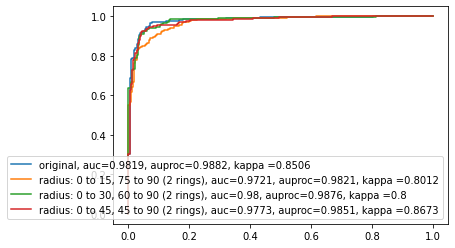

In [112]:
multi_ring_roc_radiuses = [[['0', '15'], ['75','90']], [['0', '30'], ['60', '90']], [['0','45'],['45', '90']]]

make_roc_plot("./outputs/probabilities/", 50, False, True, True, 
              multi_ring_roc_radiuses, 'dark_background',
             insert_indexes = [3], my_paths = ['shadow_regions_dark_background_90_epoch50.csv'], 
              my_labels=['radius: 0 to 45, 45 to 90 (2 rings)'])


11
['shadow_rings_dark_background_30_60_skeletonized_epoch50.csv'
 'shadow_rings_dark_background_0_30_skeletonized_epoch50.csv'
 'skeletonized_epoch50.csv'
 'shadow_rings_dark_background_60_90_skeletonized_epoch50.csv']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']
['radius: 30 to 60 (ring)' 'radius: 0 to 30 (ring)'
 'original skeletonized' 'radius: 60 to 90 (ring)']


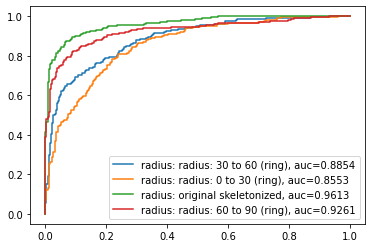

In [96]:
make_roc_plot("./outputs/probabilities/", 50, True, True, True, [['0', '30'], ['30','60'], ['60', '90']], 'dark_background')

['original_epoch50.csv' 'shadow_regions_dark_background_45_epoch50.csv'
 'shadow_regions_dark_background_60_epoch50.csv'
 'shadow_regions_dark_background_90_epoch50.csv']
['original' 'radius: 45' 'radius: 60' 'radius: 90']


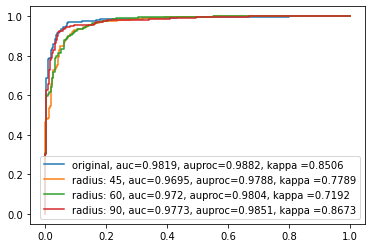

In [125]:
make_roc_plot("./outputs/probabilities/", 50, False, True, False, ['45', '60', '90'], 'dark_background')

In [ ]:
make_roc_plot("./outputs/probabilities/", 50, True, True, False, 
              ['15', '30', '45', '60', '75', '90', '105', '120'], 'dark_center',
             [1, 2], ['shadow_rings_dark_center_0_15_skeletonized_epoch50.csv', 
                      'shadow_rings_dark_center_0_30_skeletonized_epoch50.csv'], 
             ['radius: 15', 'radius: 30'])

['skeletonized_epoch50.csv'
 'shadow_rings_dark_background_45_90_skeletonized_epoch50.csv']
['original skeletonized' 'radius: 45 to 90 (ring)']


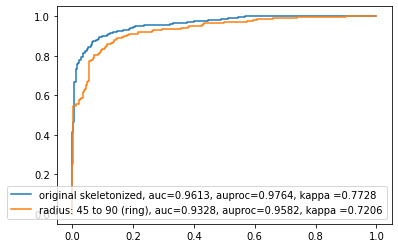

In [128]:
make_roc_plot("./outputs/probabilities/", 50, True, True, True, [['45', '90']], 'dark_background')

### AUC graphs

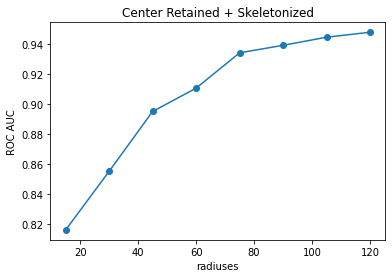

In [141]:
radiuses = [15,30,45,60,75,90,105,120]
auc = [0.8163,0.8553,0.8951,0.9106,0.9341,0.9391,0.9445,0.9478]

plt.scatter(radiuses,auc)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Center Retained + Skeletonized')

plt.plot(radiuses, auc)
plt.show()

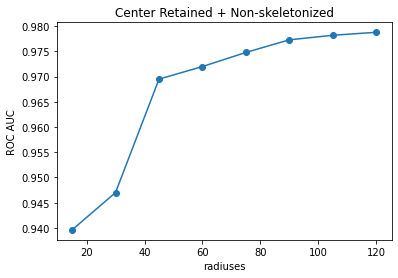

In [142]:
auc_non_skel =  [0.9396, 0.947, 0.9695, 0.9720, 0.9748, 0.9773, 0.9782, 0.9788]

plt.scatter(radiuses,auc_non_skel)
plt.plot(radiuses, auc_non_skel)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Center Retained + Non-skeletonized')

plt.show()

In [1]:
auc2 =   [0.9573, 0.9696, 0.9608, 0.9485, 0.9385, 0.8807, 0.8577, 0.7941]

plt.scatter(radiuses,auc2)
plt.plot(radiuses, auc2)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('Background Retained + Non-skeletonized')

plt.show()

NameError: name 'plt' is not defined

### Ring Results Thorugh Visualization

In [11]:
auc_skel_15_center_preserved = [0.9613, 0.8163, 0.7754, 0.8408, 0.8772, 0.8974, 0.9128]
auc_skel_30_center_preserved = [0.9613, 0.8553, 0.8854, 0.9261]

auc_non_skel_15_center_preserved = [0.9819, 0.9396, 0.8698, 0.8757, 0.8648, 0.9126, 0.9046]
auc_non_skel_30_center_preserved = [0.9819, 0.947, 0.8895, 0.9264]

radiuses_15 = ['original','0-15', '15-30', '30-45', '45-60', '60-75', '75-90']
radiuses_30 = ['original','0-30', '30-60', '60-90']

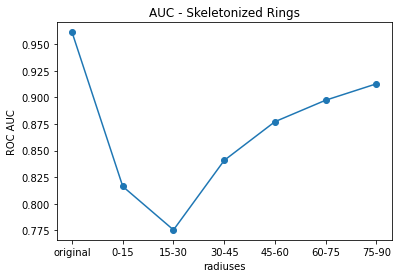

In [12]:
plt.scatter(radiuses_15,auc_skel_15_center_preserved)
plt.plot(radiuses_15, auc_skel_15_center_preserved)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Skeletonized Rings')

plt.show()

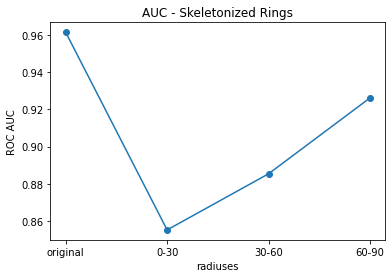

In [15]:
plt.scatter(radiuses_30,auc_skel_30_center_preserved)
plt.plot(radiuses_30, auc_skel_30_center_preserved)
plt.xlabel('radiuses')
plt.ylabel('ROC AUC')
plt.title('AUC - Skeletonized Rings')

plt.show()